## Build and train a CNN from scratch

In [1]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# import torchvision module to handle image manipulation
import torchvision
from torchvision import transforms, datasets

import time
import random
import numpy as np
import matplotlib.pyplot as plt

### MNIST dataset

In [2]:
# import MNIST train and test datasets - PIL.Image
train_PIL = datasets.MNIST(root = 'data', 
                               train = True, 
                               download = True)

test_PIL = datasets.MNIST(root = 'data', 
                              train = False, 
                              download = True)

In [3]:
# import MNIST train and test datasets - as Tensors
train_dataset = datasets.MNIST(root = "data", 
                               train = True,
                               download = True,
                               transform = transforms.Compose([
                                   transforms.ToTensor()]))
test_dataset = datasets.MNIST(root = "data", 
                              train = False,
                              download = True,
                              transform = transforms.Compose([
                                  transforms.ToTensor()]))

In [4]:
print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of testing examples: {len(test_dataset)}")

Number of training examples: 60000
Number of testing examples: 10000


In [5]:
train_PIL[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x1123FC7B8>, 5)

In [6]:
type(train_PIL[0])

tuple

In [7]:
# DataLoader No transforms:
BATCH_SIZE = 32

trainset = DataLoader(train_dataset,
                      batch_size = BATCH_SIZE,
                      shuffle = True)

testset = DataLoader(test_dataset,
                     batch_size = BATCH_SIZE,
                     shuffle = True)

In [8]:
dataiter = iter(trainset)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32])


tensor(0)


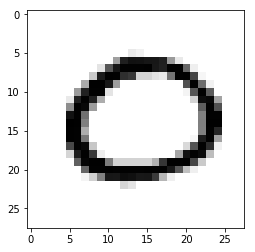

In [9]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');
print(labels[0])

In [10]:
def imshow(dataset, num_images):
    dataiter = iter(dataset)
    images, labels = dataiter.next()
    figure = plt.figure()
    num_of_images = num_images
    for index in range(1, num_of_images + 1):
        plt.subplot(6, 10, index)
        plt.axis('off')
        plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

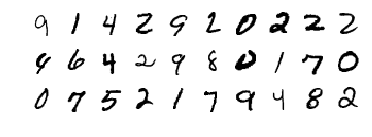

In [11]:
imshow(trainset, 30)

#### Transforms:

In [12]:
# Transforms added to resize MNIST 28x28 to be same as SVHN 32X32 
train_normal = datasets.MNIST(root = "data", 
                       train = True,
                       download = True,
                       transform = transforms.Compose([
                           transforms.Resize(32),
                           transforms.ToTensor()]))

test_normal = datasets.MNIST(root = "data", 
                       train = False,
                       download = True,
                       transform = transforms.Compose([
                           transforms.Resize(32),
                           transforms.ToTensor()]))

In [13]:
# Tranforms added to Augmented datasets:
transform_aug = transforms.Compose(
                [transforms.Resize(32),
                 transforms.RandomHorizontalFlip(),
                 transforms.RandomCrop(size=32),
                 transforms.ToTensor()])

train_augment = datasets.MNIST(root = "data", 
                       train = True,
                       download = True,
                       transform = transform_aug)

test_augment = datasets.MNIST(root = "data", 
                       train = False,
                       download = True,
                       transform = transform_aug)

In [14]:
# DataLoader 
train_norm = DataLoader(train_normal,
                      batch_size = BATCH_SIZE,
                      shuffle = True)

test_norm = DataLoader(test_normal,
                     batch_size = BATCH_SIZE,
                     shuffle = True)

train_aug = DataLoader(train_augment,
                      batch_size = BATCH_SIZE,
                      shuffle = True)

test_aug = DataLoader(test_augment,
                     batch_size = BATCH_SIZE,
                     shuffle = True)

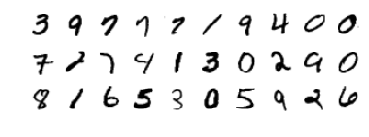

In [15]:
# Visualize NO transform:
imshow(train_norm, 30)

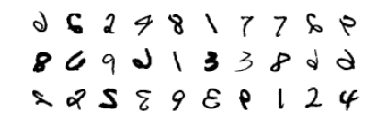

In [16]:
# Visualize Augmented Dataset:
imshow(train_aug, 30)

#### Check for Class bias (distribution):

In [17]:
# Check if data in Trainset is balanced for each class (label 0 to 9):
total = 0 
counter_dict = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}

for data in trainset:
    Xs, ys = data
    for y in ys:
        counter_dict[int(y)] += 1
        total += 1
print(counter_dict)

for key in counter_dict:
    print("{%d}: %.2f" %(key, ((counter_dict[key]/total)*100)))

{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
{0}: 9.87
{1}: 11.24
{2}: 9.93
{3}: 10.22
{4}: 9.74
{5}: 9.04
{6}: 9.86
{7}: 10.44
{8}: 9.75
{9}: 9.92


### CNN: model LeNet-5

In [18]:
# Build the neural network, expand on top of nn.Module
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()   #initializes nn.Module
        
        # define layers
        self.conv1 = nn.Conv2d(in_channels = 1,
                               out_channels = 6,
                               kernel_size = 5,
                               stride = 1
                              )
        self.conv2 = nn.Conv2d(in_channels = 6,
                               out_channels = 16,
                               kernel_size = 5,
                               stride = 1
                              )
        self.conv3 = nn.Conv2d(in_channels = 16,
                               out_channels = 120,
                               kernel_size = 5,
                               stride = 1
                              )
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)
    
    def forward(self, x):
        # conv1
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 
                         kernel_size = 2,
                         stride = 2
                        )
        # conv2
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 
                         kernel_size = 2,
                         stride = 2
                        )
        # conv3
        x = self.conv3(x)
        x = F.relu(x)
    
        x = x.view(x.shape[0], -1) # flatten/ reshape
        
        #fc1
        x = self.fc1(x)
        x = F.relu(x)
        
        #fc2
        x = self.fc2(x)
        
        return x

In [19]:
net = LeNet5()
print(net)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


### Loss Function and Optimizer

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [21]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 5, 5])


### Training the Model

In [22]:
def accuracy(ypred, target):
    preds = ypred.argmax(1, keepdim = True)
    total = preds.shape[0]
    correct = preds.eq(target.view_as(preds)).sum()
    acc = correct.float() / total
    return acc

In [23]:
def train(model, train_iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    total_step = len(train_iterator)
    for data in train_iterator: 
        X, target = data                          # data is a list of [inputs, target]
        
        # Run the forward pass
        output = model(X)
        loss = criterion(output, target)
        epoch_loss += loss.item()
        
        # Backprop and optimize
        optimizer.zero_grad()                     # zeroes the gradient buffers of all parameters
        loss.backward()
        optimizer.step()

        # Track accuracy
        acc = accuracy(output, target)
        epoch_acc += acc.item()

    return epoch_loss / total_step, epoch_acc / total_step

In [24]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time/60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#### Training non-augmented dataset:

In [25]:
EPOCHS = 10
loss_norm = []

for epoch in range(EPOCHS):                       # loop over the dataset multiple times
        start_time = time.time()
        train_loss, train_acc = train(net, train_norm, optimizer, criterion)
        loss_norm.append(train_loss)
        end_time = time.time()
        mins, secs = epoch_time(start_time, end_time)
        
        print(f'Epoch: {epoch+1:02} | Epoch Time: {mins}m {secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        
        if train_loss == 0:
            break

Epoch: 01 | Epoch Time: 0m 23s
	Train Loss: 0.345 | Train Acc: 88.57%
Epoch: 02 | Epoch Time: 0m 25s
	Train Loss: 0.065 | Train Acc: 98.00%
Epoch: 03 | Epoch Time: 0m 25s
	Train Loss: 0.046 | Train Acc: 98.53%
Epoch: 04 | Epoch Time: 0m 25s
	Train Loss: 0.036 | Train Acc: 98.83%
Epoch: 05 | Epoch Time: 0m 25s
	Train Loss: 0.031 | Train Acc: 99.01%
Epoch: 06 | Epoch Time: 0m 24s
	Train Loss: 0.025 | Train Acc: 99.20%
Epoch: 07 | Epoch Time: 0m 23s
	Train Loss: 0.021 | Train Acc: 99.32%
Epoch: 08 | Epoch Time: 0m 25s
	Train Loss: 0.018 | Train Acc: 99.44%
Epoch: 09 | Epoch Time: 0m 25s
	Train Loss: 0.015 | Train Acc: 99.54%
Epoch: 10 | Epoch Time: 0m 25s
	Train Loss: 0.012 | Train Acc: 99.60%


#### Training Augmented dataset:

In [26]:
EPOCHS = 10
loss_aug = []

for epoch in range(EPOCHS):                       # loop over the dataset multiple times        
        start_time = time.time()
        train_loss, train_acc = train(net, train_aug, optimizer, criterion)
        loss_aug.append(train_loss)
        end_time = time.time()
        mins, secs = epoch_time(start_time, end_time)
        
        print(f'Epoch: {epoch+1:02} | Epoch Time: {mins}m {secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        
        if train_loss == 0:
            break

Epoch: 01 | Epoch Time: 0m 26s
	Train Loss: 0.121 | Train Acc: 96.31%
Epoch: 02 | Epoch Time: 0m 26s
	Train Loss: 0.064 | Train Acc: 97.97%
Epoch: 03 | Epoch Time: 0m 26s
	Train Loss: 0.051 | Train Acc: 98.36%
Epoch: 04 | Epoch Time: 0m 26s
	Train Loss: 0.046 | Train Acc: 98.55%
Epoch: 05 | Epoch Time: 0m 27s
	Train Loss: 0.040 | Train Acc: 98.70%
Epoch: 06 | Epoch Time: 0m 26s
	Train Loss: 0.037 | Train Acc: 98.84%
Epoch: 07 | Epoch Time: 0m 26s
	Train Loss: 0.033 | Train Acc: 98.95%
Epoch: 08 | Epoch Time: 0m 27s
	Train Loss: 0.031 | Train Acc: 99.02%
Epoch: 09 | Epoch Time: 0m 26s
	Train Loss: 0.026 | Train Acc: 99.17%
Epoch: 10 | Epoch Time: 0m 25s
	Train Loss: 0.024 | Train Acc: 99.21%


#### Plot of loss during training per epoch

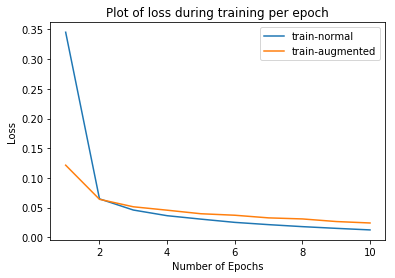

In [28]:
x = range(1,EPOCHS+1)
y1 = loss_norm
y2 = loss_aug
plt.plot(x, y1, label="train-normal")
plt.plot(x, y2, label="train-augmented")
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title("Plot of loss during training per epoch")
plt.legend()

### Testing the model

In [42]:
def test(model, test_iterator, criterion):
    correct_idx = []
    wrong_idx = []
    test_dict = {}
    preds = []
    
    model.eval()
    test_loss = 0
    correct = 0
    total_step = len(test_iterator)
    with torch.no_grad():
        for i, data in enumerate(test_iterator):
            X, target = data
            test_dict[i] = (X, target)
            
            # Run the forward pass
            output = model(X)
            loss = criterion(output, target)
            test_loss += loss.item()
            
            # Track accuracy
            acc = accuracy(output, target)
            correct += acc.item()
            
            # Store index of correct and wrong predictions
            pred = output.argmax(dim=1, keepdim=True)
            preds.append(pred)
            c = [i for i, val in enumerate(pred.eq(target.view_as(pred))) if (val==True)] 
            w = [i for i, val in enumerate(pred.eq(target.view_as(pred))) if (val==False)] 
            correct_idx.append(c)
            wrong_idx.append(w)

    return test_loss / total_step, correct / total_step, correct_idx, wrong_idx, test_dict, preds

In [43]:
test_loss, test_acc, c_id, w_id, test_dict, preds = test(net, test_norm, criterion)
print(f'\t No Augmentation-- Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

	 No Augmentation-- Test Loss: 0.055 | Test Acc: 98.39%


In [44]:
test_loss, test_acc, c_id_aug, w_id_aug, test_dict_aug, preds_aug = test(net, test_aug, criterion)
print(f'\t Augmentation-- Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

	 Augmentation-- Test Loss: 0.053 | Test Acc: 98.52%


### Visualizing Correct and Wrong Predictions
printing only for not-augmented test dataset

In [45]:
print(f"Total number of batches: {len(preds)}")

Total number of batches: 313


In [46]:
# finding batch with most wrong predictions
w_lens =[]
wrong_idx = np.array(w_id)
for i, w_i in enumerate(wrong_idx):
    w_lens.append(len(wrong_idx[i]))
batch_num = w_lens.index(max(w_lens))
print(f"wrong_idx: batch #{batch_num} with maximum #{max(w_lens)} wrong predictions.")

wrong_idx: batch #38 with maximum #3 wrong predictions.


In [47]:
# finding batch with least correct predictions
# **Note should be same batch# as above
c_lens =[]
correct_idx = np.array(c_id)
for i, c_i in enumerate(correct_idx):
    c_lens.append(len(correct_idx[i]))
batch_num = c_lens.index(min(c_lens[:-1]))
print(f"correct_idx: batch #{batch_num} with minimum #{min(c_lens[:-1])} correct predictions.")
#Note: [:-1] convention is used since the last list does not have same batch elements as other batches

correct_idx: batch #38 with minimum #29 correct predictions.


In [58]:
Xs = test_dict[batch_num][0]
targets = test_dict[batch_num][1]
ypreds = preds[batch_num]

#### Visualizing Wrong Predictions

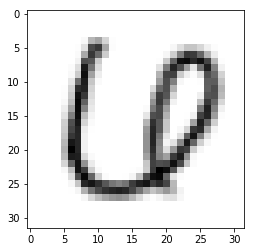

The target label is 6.
The prediction label is 0.


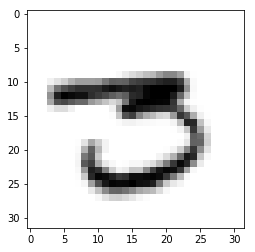

The target label is 3.
The prediction label is 5.


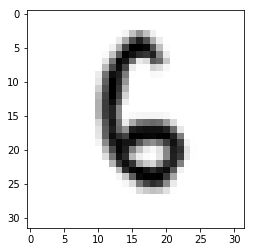

The target label is 6.
The prediction label is 2.


In [59]:
plt.figure()
for i, w_idx in enumerate(wrong_idx[batch_num]):
    plt.imshow(Xs[w_idx].numpy().squeeze(), cmap='gray_r')
    plt.show()
    print(f"The target label is {targets[w_idx]}.")
    print(f"The prediction label is {ypreds[w_idx][0]}.")

#### Visualizing Correct Predictions

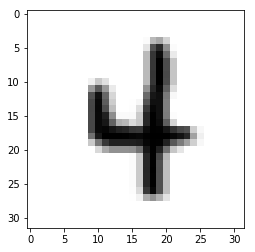

The target label is 4.
The prediction label is 4.


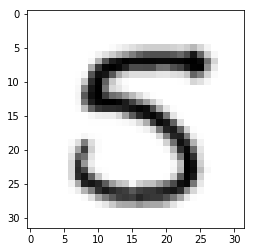

The target label is 5.
The prediction label is 5.


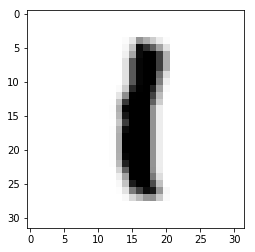

The target label is 1.
The prediction label is 1.


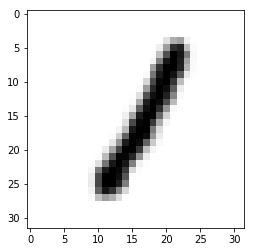

The target label is 1.
The prediction label is 1.


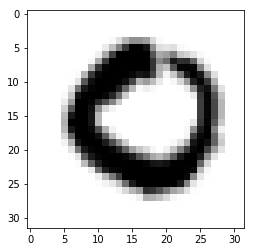

The target label is 0.
The prediction label is 0.


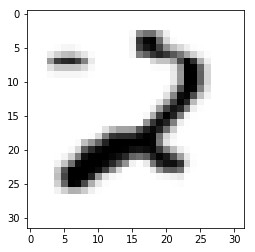

The target label is 2.
The prediction label is 2.


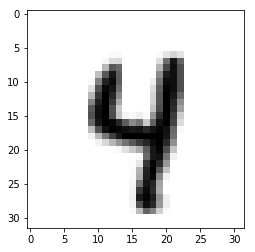

The target label is 4.
The prediction label is 4.


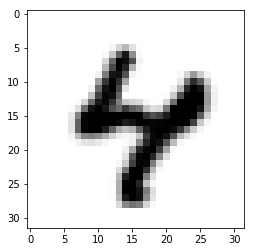

The target label is 4.
The prediction label is 4.


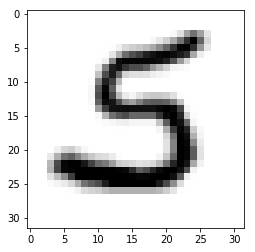

The target label is 5.
The prediction label is 5.


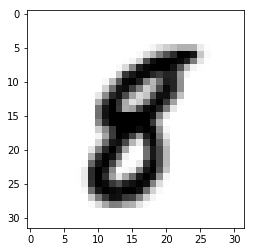

The target label is 8.
The prediction label is 8.


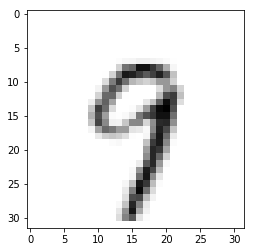

The target label is 9.
The prediction label is 9.


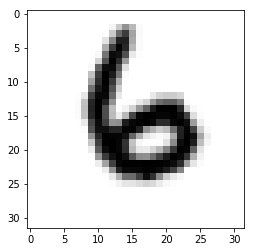

The target label is 6.
The prediction label is 6.


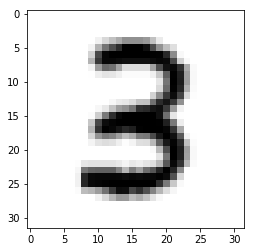

The target label is 3.
The prediction label is 3.


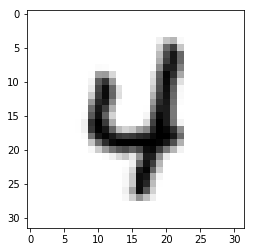

The target label is 4.
The prediction label is 4.


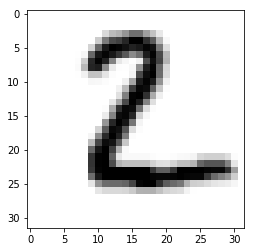

The target label is 2.
The prediction label is 2.


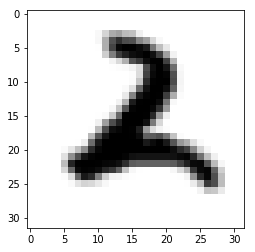

The target label is 2.
The prediction label is 2.


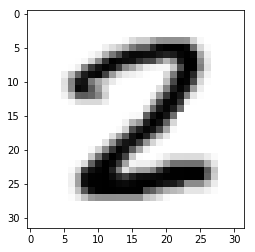

The target label is 2.
The prediction label is 2.


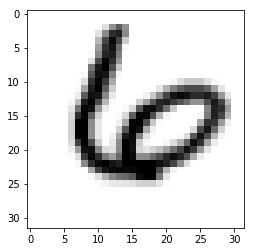

The target label is 6.
The prediction label is 6.


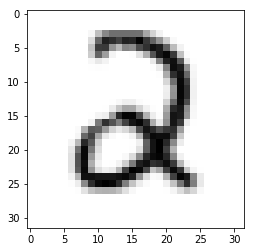

The target label is 2.
The prediction label is 2.


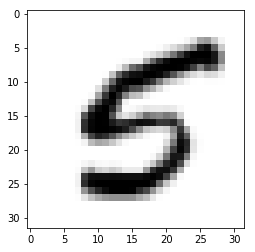

The target label is 5.
The prediction label is 5.


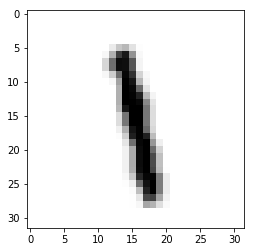

The target label is 1.
The prediction label is 1.


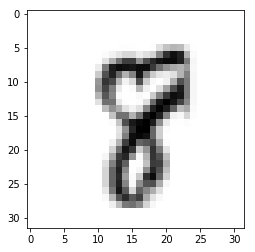

The target label is 8.
The prediction label is 8.


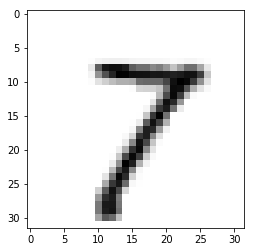

The target label is 7.
The prediction label is 7.


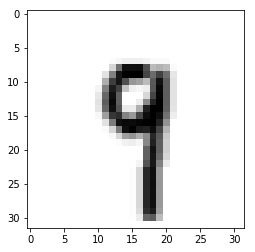

The target label is 9.
The prediction label is 9.


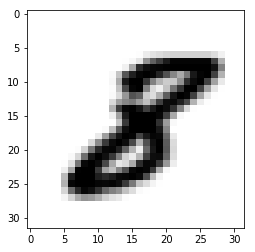

The target label is 8.
The prediction label is 8.


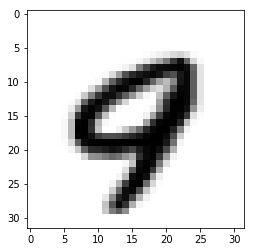

The target label is 9.
The prediction label is 9.


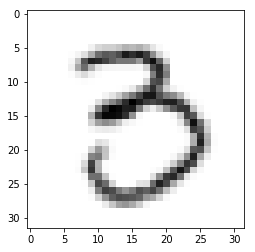

The target label is 3.
The prediction label is 3.


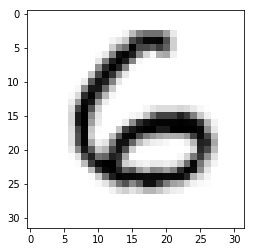

The target label is 6.
The prediction label is 6.


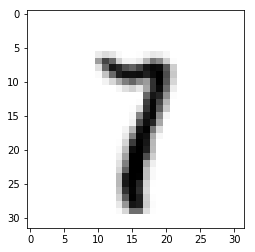

The target label is 7.
The prediction label is 7.


In [60]:
plt.figure()
for i, c_idx in enumerate(correct_idx[batch_num]):
    plt.imshow(Xs[c_idx].numpy().squeeze(), cmap='gray_r')
    plt.show()
    print(f"The target label is {targets[c_idx]}.")
    print(f"The prediction label is {ypreds[c_idx][0]}.")